In [2]:
%pip install -U \
  torch==2.0.1 \
  accelerate==0.24.1 \
  transformers==4.35.2 \
  torchvision==0.15.2 \
  diffusers==0.23.1 \
  xformers==0.0.21 \
  bitsandbytes==0.41.1

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Dataset

In [3]:
local_dir = "./images_molly"

Preview the images:

In [4]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

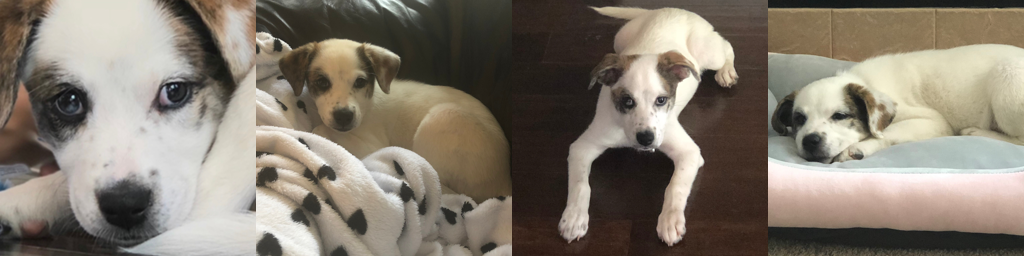

In [5]:
import glob

#imgs = [Image.open(path) for path in glob.glob("./images_dreambooth/*.jpeg")]
imgs = [Image.open(path) for path in glob.glob("./images_molly/*.jpg")]
image_grid(imgs, 1, 4)

# Train

In [6]:
import argparse
import copy
import gc
import importlib
import itertools
import logging
import math
import os
import shutil
import warnings
from pathlib import Path

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from huggingface_hub import create_repo, model_info, upload_folder
from huggingface_hub.utils import insecure_hashlib
from packaging import version
from PIL import Image
from PIL.ImageOps import exif_transpose
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig

import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)
from diffusers.optimization import get_scheduler
from diffusers.training_utils import compute_snr
from diffusers.utils import check_min_version
from diffusers.utils.import_utils import is_xformers_available

logger = get_logger(__name__)

In [7]:
parser = argparse.ArgumentParser(description="Simple example of a training script.")
parser.add_argument(
    "--pretrained_model_name_or_path",
    type=str,
    default="runwayml/stable-diffusion-v1-5",
    help="Path to pretrained model or model identifier from huggingface.co/models.",
)
parser.add_argument(
    "--revision",
    type=str,
    default=None,
    required=False,
    help=(
        "Revision of pretrained model identifier from huggingface.co/models. Trainable model components should be"
        " float32 precision."
    ),
)
parser.add_argument(
    "--tokenizer_name",
    type=str,
    default=None,
    help="Pretrained tokenizer name or path if not the same as model_name",
)
parser.add_argument(
    "--instance_data_dir",
    type=str,
    default="images_molly",
    help="A folder containing the training data of instance images.",
)
parser.add_argument(
    "--class_data_dir",
    type=str,
    default=None,
    required=False,
    help="A folder containing the training data of class images.",
)
parser.add_argument(
    "--instance_prompt",
    type=str,
    default="a photo of molly dog",
    help="The prompt with identifier specifying the instance",
)
parser.add_argument(
    "--class_prompt",
    type=str,
    default=None,
    help="The prompt to specify images in the same class as provided instance images.",
)
parser.add_argument(
    "--with_prior_preservation",
    default=False,
    action="store_true",
    help="Flag to add prior preservation loss.",
)
parser.add_argument("--prior_loss_weight", type=float, default=1.0, help="The weight of prior preservation loss.")
parser.add_argument(
    "--num_class_images",
    type=int,
    default=200,
    help=(
        "Minimal class images for prior preservation loss. If there are not enough images already present in"
        " class_data_dir, additional images will be sampled with class_prompt."
    ),
)
parser.add_argument(
    "--output_dir",
    type=str,
    default="dreambooth_model",
    help="The output directory where the model predictions and checkpoints will be written.",
)
parser.add_argument("--seed", type=int, default=None, help="A seed for reproducible training.")
parser.add_argument(
    "--resolution",
    type=int,
    default=512,
    help=(
        "The resolution for input images, all the images in the train/validation dataset will be resized to this"
        " resolution"
    ),
)
parser.add_argument(
    "--center_crop",
    default=False,
    action="store_true",
    help=(
        "Whether to center crop the input images to the resolution. If not set, the images will be randomly"
        " cropped. The images will be resized to the resolution first before cropping."
    ),
)
parser.add_argument(
    "--train_text_encoder",
    action="store_true",
    help="Whether to train the text encoder. If set, the text encoder should be float32 precision.",
)
parser.add_argument(
    "--train_batch_size", type=int, default=4, help="Batch size (per device) for the training dataloader."
)
parser.add_argument(
    "--sample_batch_size", type=int, default=4, help="Batch size (per device) for sampling images."
)
parser.add_argument("--num_train_epochs", type=int, default=1)
parser.add_argument(
    "--max_train_steps",
    type=int,
    default=None,
    help="Total number of training steps to perform.  If provided, overrides num_train_epochs.",
)
parser.add_argument(
    "--checkpointing_steps",
    type=int,
    default=500,
    help=(
        "Save a checkpoint of the training state every X updates. Checkpoints can be used for resuming training via `--resume_from_checkpoint`. "
        "In the case that the checkpoint is better than the final trained model, the checkpoint can also be used for inference."
        "Using a checkpoint for inference requires separate loading of the original pipeline and the individual checkpointed model components."
        "See https://huggingface.co/docs/diffusers/main/en/training/dreambooth#performing-inference-using-a-saved-checkpoint for step by step"
        "instructions."
    ),
)
parser.add_argument(
    "--checkpoints_total_limit",
    type=int,
    default=None,
    help=(
        "Max number of checkpoints to store. Passed as `total_limit` to the `Accelerator` `ProjectConfiguration`."
        " See Accelerator::save_state https://huggingface.co/docs/accelerate/package_reference/accelerator#accelerate.Accelerator.save_state"
        " for more details"
    ),
)
parser.add_argument(
    "--resume_from_checkpoint",
    type=str,
    default=None,
    help=(
        "Whether training should be resumed from a previous checkpoint. Use a path saved by"
        ' `--checkpointing_steps`, or `"latest"` to automatically select the last available checkpoint.'
    ),
)
parser.add_argument(
    "--gradient_accumulation_steps",
    type=int,
    default=1,
    help="Number of updates steps to accumulate before performing a backward/update pass.",
)
parser.add_argument(
    "--gradient_checkpointing",
    action="store_true",
    help="Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.",
)
parser.add_argument(
    "--learning_rate",
    type=float,
    default=1e-4,
    help="Initial learning rate (after the potential warmup period) to use.",
)
parser.add_argument(
    "--scale_lr",
    action="store_true",
    default=False,
    help="Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.",
)
parser.add_argument(
    "--lr_scheduler",
    type=str,
    default="constant",
    help=(
        'The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial",'
        ' "constant", "constant_with_warmup"]'
    ),
)
parser.add_argument(
    "--lr_warmup_steps", 
    type=int, 
    default=0, 
    help="Number of steps for the warmup in the lr scheduler."
)
parser.add_argument(
    "--lr_num_cycles",
    type=int,
    default=1,
    help="Number of hard resets of the lr in cosine_with_restarts scheduler.",
)
parser.add_argument("--lr_power", type=float, default=1.0, help="Power factor of the polynomial scheduler.")
parser.add_argument(
    "--use_8bit_adam", action="store_true", help="Whether or not to use 8-bit Adam from bitsandbytes."
)
parser.add_argument(
    "--dataloader_num_workers",
    type=int,
    default=0,
    help=(
        "Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process."
    ),
)
parser.add_argument("--adam_beta1", type=float, default=0.9, help="The beta1 parameter for the Adam optimizer.")
parser.add_argument("--adam_beta2", type=float, default=0.999, help="The beta2 parameter for the Adam optimizer.")
parser.add_argument("--adam_weight_decay", type=float, default=1e-2, help="Weight decay to use.")
parser.add_argument("--adam_epsilon", type=float, default=1e-08, help="Epsilon value for the Adam optimizer")
parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
parser.add_argument("--push_to_hub", action="store_true", help="Whether or not to push the model to the Hub.")
parser.add_argument("--hub_token", type=str, default=None, help="The token to use to push to the Model Hub.")
parser.add_argument(
    "--hub_model_id",
    type=str,
    default=None,
    help="The name of the repository to keep in sync with the local `output_dir`.",
)
parser.add_argument(
    "--logging_dir",
    type=str,
    default="logs",
    help=(
        "[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to"
        " *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."
    ),
)
parser.add_argument(
    "--allow_tf32",
    action="store_true",
    help=(
        "Whether or not to allow TF32 on Ampere GPUs. Can be used to speed up training. For more information, see"
        " https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices"
    ),
)
parser.add_argument(
    "--report_to",
    type=str,
    default="tensorboard",
    help=(
        'The integration to report the results and logs to. Supported platforms are `"tensorboard"`'
        ' (default), `"wandb"` and `"comet_ml"`. Use `"all"` to report to all integrations.'
    ),
)
parser.add_argument(
    "--validation_prompt",
    type=str,
    default=None,
    help="A prompt that is used during validation to verify that the model is learning.",
)
parser.add_argument(
    "--num_validation_images",
    type=int,
    default=4,
    help="Number of images that should be generated during validation with `validation_prompt`.",
)
parser.add_argument(
    "--validation_steps",
    type=int,
    default=100,
    help=(
        "Run validation every X steps. Validation consists of running the prompt"
        " `args.validation_prompt` multiple times: `args.num_validation_images`"
        " and logging the images."
    ),
)
parser.add_argument(
    "--mixed_precision",
    type=str,
    default=None,
    choices=["no", "fp16", "bf16"],
    help=(
        "Whether to use mixed precision. Choose between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >="
        " 1.10.and an Nvidia Ampere GPU.  Default to the value of accelerate config of the current system or the"
        " flag passed with the `accelerate.launch` command. Use this argument to override the accelerate config."
    ),
)
parser.add_argument(
    "--prior_generation_precision",
    type=str,
    default=None,
    choices=["no", "fp32", "fp16", "bf16"],
    help=(
        "Choose prior generation precision between fp32, fp16 and bf16 (bfloat16). Bf16 requires PyTorch >="
        " 1.10.and an Nvidia Ampere GPU.  Default to  fp16 if a GPU is available else fp32."
    ),
)
parser.add_argument("--local_rank", type=int, default=-1, help="For distributed training: local_rank")
parser.add_argument(
    "--enable_xformers_memory_efficient_attention", action="store_true", help="Whether or not to use xformers."
)
parser.add_argument(
    "--set_grads_to_none",
    action="store_true",
    help=(
        "Save more memory by using setting grads to None instead of zero. Be aware, that this changes certain"
        " behaviors, so disable this argument if it causes any problems. More info:"
        " https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html"
    ),
)

parser.add_argument(
    "--offset_noise",
    action="store_true",
    default=False,
    help=(
        "Fine-tuning against a modified noise"
        " See: https://www.crosslabs.org//blog/diffusion-with-offset-noise for more information."
    ),
)
parser.add_argument(
    "--snr_gamma",
    type=float,
    default=None,
    help="SNR weighting gamma to be used if rebalancing the loss. Recommended value is 5.0. "
    "More details here: https://arxiv.org/abs/2303.09556.",
)
parser.add_argument(
    "--pre_compute_text_embeddings",
    action="store_true",
    help="Whether or not to pre-compute text embeddings. If text embeddings are pre-computed, the text encoder will not be kept in memory during training and will leave more GPU memory available for training the rest of the model. This is not compatible with `--train_text_encoder`.",
)
parser.add_argument(
    "--tokenizer_max_length",
    type=int,
    default=None,
    required=False,
    help="The maximum length of the tokenizer. If not set, will default to the tokenizer's max length.",
)
parser.add_argument(
    "--text_encoder_use_attention_mask",
    action="store_true",
    required=False,
    help="Whether to use attention mask for the text encoder",
)
parser.add_argument(
    "--skip_save_text_encoder", action="store_true", required=False, help="Set to not save text encoder"
)
parser.add_argument(
    "--validation_images",
    required=False,
    default=None,
    nargs="+",
    help="Optional set of images to use for validation. Used when the target pipeline takes an initial image as input such as when training image variation or superresolution.",
)
parser.add_argument(
    "--class_labels_conditioning",
    required=False,
    default=None,
    help="The optional `class_label` conditioning to pass to the unet, available values are `timesteps`.",
)
parser.add_argument(
    "--validation_scheduler",
    type=str,
    default="DPMSolverMultistepScheduler",
    choices=["DPMSolverMultistepScheduler", "DDPMScheduler"],
    help="Select which scheduler to use for validation. DDPMScheduler is recommended for DeepFloyd IF.",
)

args, _ = parser.parse_known_args()

env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
if env_local_rank != -1 and env_local_rank != args.local_rank:
    args.local_rank = env_local_rank

if args.with_prior_preservation:
    if args.class_data_dir is None:
        raise ValueError("You must specify a data directory for class images.")
    if args.class_prompt is None:
        raise ValueError("You must specify prompt for class images.")
else:
    # logger is not available yet
    if args.class_data_dir is not None:
        warnings.warn("You need not use --class_data_dir without --with_prior_preservation.")
    if args.class_prompt is not None:
        warnings.warn("You need not use --class_prompt without --with_prior_preservation.")

if args.train_text_encoder and args.pre_compute_text_embeddings:
    raise ValueError("`--train_text_encoder` cannot be used with `--pre_compute_text_embeddings`")
    
print(args)

Namespace(pretrained_model_name_or_path='runwayml/stable-diffusion-v1-5', revision=None, tokenizer_name=None, instance_data_dir='images_molly', class_data_dir=None, instance_prompt='a photo of molly dog', class_prompt=None, with_prior_preservation=False, prior_loss_weight=1.0, num_class_images=200, output_dir='dreambooth_model', seed=None, resolution=512, center_crop=False, train_text_encoder=False, train_batch_size=4, sample_batch_size=4, num_train_epochs=1, max_train_steps=None, checkpointing_steps=500, checkpoints_total_limit=None, resume_from_checkpoint=None, gradient_accumulation_steps=1, gradient_checkpointing=False, learning_rate=0.0001, scale_lr=False, lr_scheduler='constant', lr_warmup_steps=0, lr_num_cycles=1, lr_power=1.0, use_8bit_adam=False, dataloader_num_workers=0, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.01, adam_epsilon=1e-08, max_grad_norm=1.0, push_to_hub=False, hub_token=None, hub_model_id=None, logging_dir='logs', allow_tf32=False, report_to='tensorboa

In [8]:
def log_validation(
    text_encoder,
    tokenizer,
    unet,
    vae,
    args,
    accelerator,
    weight_dtype,
    global_step,
    prompt_embeds,
    negative_prompt_embeds,
):
    logger.info(
        f"Running validation... \n Generating {args.num_validation_images} images with prompt:"
        f" {args.validation_prompt}."
    )

    pipeline_args = {}

    if vae is not None:
        pipeline_args["vae"] = vae

    if text_encoder is not None:
        text_encoder = accelerator.unwrap_model(text_encoder)

    # create pipeline (note: unet and vae are loaded again in float32)
    pipeline = DiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        tokenizer=tokenizer,
        text_encoder=text_encoder,
        unet=accelerator.unwrap_model(unet),
        revision=args.revision,
        torch_dtype=weight_dtype,
        **pipeline_args,
    )

    # We train on the simplified learning objective. If we were previously predicting a variance, we need the scheduler to ignore it
    scheduler_args = {}

    if "variance_type" in pipeline.scheduler.config:
        variance_type = pipeline.scheduler.config.variance_type

        if variance_type in ["learned", "learned_range"]:
            variance_type = "fixed_small"

        scheduler_args["variance_type"] = variance_type

    module = importlib.import_module("diffusers")
    scheduler_class = getattr(module, args.validation_scheduler)
    pipeline.scheduler = scheduler_class.from_config(pipeline.scheduler.config, **scheduler_args)
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    if args.pre_compute_text_embeddings:
        pipeline_args = {
            "prompt_embeds": prompt_embeds,
            "negative_prompt_embeds": negative_prompt_embeds,
        }
    else:
        pipeline_args = {"prompt": args.validation_prompt}

    # run inference
    generator = None if args.seed is None else torch.Generator(device=accelerator.device).manual_seed(args.seed)
    images = []
    if args.validation_images is None:
        for _ in range(args.num_validation_images):
            with torch.autocast("cuda"):
                image = pipeline(**pipeline_args, num_inference_steps=25, generator=generator).images[0]
            images.append(image)
    else:
        for image in args.validation_images:
            image = Image.open(image)
            image = pipeline(**pipeline_args, image=image, generator=generator).images[0]
            images.append(image)

    for tracker in accelerator.trackers:
        if tracker.name == "tensorboard":
            np_images = np.stack([np.asarray(img) for img in images])
            tracker.writer.add_images("validation", np_images, global_step, dataformats="NHWC")
        if tracker.name == "wandb":
            tracker.log(
                {
                    "validation": [
                        wandb.Image(image, caption=f"{i}: {args.validation_prompt}") for i, image in enumerate(images)
                    ]
                }
            )

    del pipeline
    torch.cuda.empty_cache()

    return images


def import_model_class_from_model_name_or_path(pretrained_model_name_or_path: str, revision: str):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "RobertaSeriesModelWithTransformation":
        from diffusers.pipelines.alt_diffusion.modeling_roberta_series import RobertaSeriesModelWithTransformation

        return RobertaSeriesModelWithTransformation
    elif model_class == "T5EncoderModel":
        from transformers import T5EncoderModel

        return T5EncoderModel
    else:
        raise ValueError(f"{model_class} is not supported.")

In [9]:
class DreamBoothDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        class_num=None,
        size=512,
        center_crop=False,
        encoder_hidden_states=None,
        class_prompt_encoder_hidden_states=None,
        tokenizer_max_length=None,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer
        self.encoder_hidden_states = encoder_hidden_states
        self.class_prompt_encoder_hidden_states = class_prompt_encoder_hidden_states
        self.tokenizer_max_length = tokenizer_max_length

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError(f"Instance {self.instance_data_root} images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(self.class_data_root.iterdir())
            if class_num is not None:
                self.num_class_images = min(len(self.class_images_path), class_num)
            else:
                self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        instance_image = exif_transpose(instance_image)

        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)

        if self.encoder_hidden_states is not None:
            example["instance_prompt_ids"] = self.encoder_hidden_states
        else:
            text_inputs = tokenize_prompt(
                self.tokenizer, self.instance_prompt, tokenizer_max_length=self.tokenizer_max_length
            )
            example["instance_prompt_ids"] = text_inputs.input_ids
            example["instance_attention_mask"] = text_inputs.attention_mask

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            class_image = exif_transpose(class_image)

            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)

            if self.class_prompt_encoder_hidden_states is not None:
                example["class_prompt_ids"] = self.class_prompt_encoder_hidden_states
            else:
                class_text_inputs = tokenize_prompt(
                    self.tokenizer, self.class_prompt, tokenizer_max_length=self.tokenizer_max_length
                )
                example["class_prompt_ids"] = class_text_inputs.input_ids
                example["class_attention_mask"] = class_text_inputs.attention_mask

        return example


def collate_fn(examples, with_prior_preservation=False):
    has_attention_mask = "instance_attention_mask" in examples[0]

    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]

    if has_attention_mask:
        attention_mask = [example["instance_attention_mask"] for example in examples]

    # Concat class and instance examples for prior preservation.
    # We do this to avoid doing two forward passes.
    if with_prior_preservation:
        input_ids += [example["class_prompt_ids"] for example in examples]
        pixel_values += [example["class_images"] for example in examples]

        if has_attention_mask:
            attention_mask += [example["class_attention_mask"] for example in examples]

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = torch.cat(input_ids, dim=0)

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }

    if has_attention_mask:
        attention_mask = torch.cat(attention_mask, dim=0)
        batch["attention_mask"] = attention_mask

    return batch


class PromptDataset(Dataset):
    "A simple dataset to prepare the prompts to generate class images on multiple GPUs."

    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example


def model_has_vae(args):
    config_file_name = os.path.join("vae", AutoencoderKL.config_name)
    if os.path.isdir(args.pretrained_model_name_or_path):
        config_file_name = os.path.join(args.pretrained_model_name_or_path, config_file_name)
        return os.path.isfile(config_file_name)
    else:
        files_in_repo = model_info(args.pretrained_model_name_or_path, revision=args.revision).siblings
        return any(file.rfilename == config_file_name for file in files_in_repo)


def tokenize_prompt(tokenizer, prompt, tokenizer_max_length=None):
    if tokenizer_max_length is not None:
        max_length = tokenizer_max_length
    else:
        max_length = tokenizer.model_max_length

    text_inputs = tokenizer(
        prompt,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt",
    )

    return text_inputs


def encode_prompt(text_encoder, input_ids, attention_mask, text_encoder_use_attention_mask=None):
    text_input_ids = input_ids.to(text_encoder.device)

    if text_encoder_use_attention_mask:
        attention_mask = attention_mask.to(text_encoder.device)
    else:
        attention_mask = None

    prompt_embeds = text_encoder(
        text_input_ids,
        attention_mask=attention_mask,
    )
    prompt_embeds = prompt_embeds[0]

    return prompt_embeds

In [10]:
logging_dir = Path(args.output_dir, args.logging_dir)

accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)

accelerator = Accelerator(
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    mixed_precision=args.mixed_precision,
    log_with=args.report_to,
    project_config=accelerator_project_config,
)

if args.report_to == "wandb":
    if not is_wandb_available():
        raise ImportError("Make sure to install wandb if you want to use it for logging during training.")

# Currently, it's not possible to do gradient accumulation when training two models with accelerate.accumulate
# This will be enabled soon in accelerate. For now, we don't allow gradient accumulation when training two models.
# TODO (patil-suraj): Remove this check when gradient accumulation with two models is enabled in accelerate.
if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
    raise ValueError(
        "Gradient accumulation is not supported when training the text encoder in distributed training. "
        "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
    )

# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state, main_process_only=False)
if accelerator.is_local_main_process:
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()

# If passed along, set the training seed now.
if args.seed is not None:
    set_seed(args.seed)

# Generate class images if prior preservation is enabled.
if args.with_prior_preservation:
    class_images_dir = Path(args.class_data_dir)
    if not class_images_dir.exists():
        class_images_dir.mkdir(parents=True)
    cur_class_images = len(list(class_images_dir.iterdir()))

    if cur_class_images < args.num_class_images:
        torch_dtype = torch.float16 if accelerator.device.type == "cuda" else torch.float32
        if args.prior_generation_precision == "fp32":
            torch_dtype = torch.float32
        elif args.prior_generation_precision == "fp16":
            torch_dtype = torch.float16
        elif args.prior_generation_precision == "bf16":
            torch_dtype = torch.bfloat16
        pipeline = DiffusionPipeline.from_pretrained(
            args.pretrained_model_name_or_path,
            torch_dtype=torch_dtype,
            safety_checker=None,
            revision=args.revision,
        )
        pipeline.set_progress_bar_config(disable=True)

        num_new_images = args.num_class_images - cur_class_images
        logger.info(f"Number of class images to sample: {num_new_images}.")

        sample_dataset = PromptDataset(args.class_prompt, num_new_images)
        sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=args.sample_batch_size)

        sample_dataloader = accelerator.prepare(sample_dataloader)
        pipeline.to(accelerator.device)

        for example in tqdm(
            sample_dataloader, desc="Generating class images", disable=not accelerator.is_local_main_process
        ):
            images = pipeline(example["prompt"]).images

            for i, image in enumerate(images):
                hash_image = insecure_hashlib.sha1(image.tobytes()).hexdigest()
                image_filename = class_images_dir / f"{example['index'][i] + cur_class_images}-{hash_image}.jpg"
                image.save(image_filename)

        del pipeline
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Handle the repository creation
if accelerator.is_main_process:
    if args.output_dir is not None:
        os.makedirs(args.output_dir, exist_ok=True)

# Load the tokenizer
if args.tokenizer_name:
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, revision=args.revision, use_fast=False)
elif args.pretrained_model_name_or_path:
    tokenizer = AutoTokenizer.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="tokenizer",
        revision=args.revision,
        use_fast=False,
    )

# import correct text encoder class
text_encoder_cls = import_model_class_from_model_name_or_path(args.pretrained_model_name_or_path, args.revision)

# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
text_encoder = text_encoder_cls.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision
)

if model_has_vae(args):
    vae = AutoencoderKL.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="vae", revision=args.revision
    )
else:
    vae = None

unet = UNet2DConditionModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision
)

# create custom saving & loading hooks so that `accelerator.save_state(...)` serializes in a nice format
def save_model_hook(models, weights, output_dir):
    if accelerator.is_main_process:
        for model in models:
            sub_dir = "unet" if isinstance(model, type(accelerator.unwrap_model(unet))) else "text_encoder"
            model.save_pretrained(os.path.join(output_dir, sub_dir))

            # make sure to pop weight so that corresponding model is not saved again
            weights.pop()

def load_model_hook(models, input_dir):
    while len(models) > 0:
        # pop models so that they are not loaded again
        model = models.pop()

        if isinstance(model, type(accelerator.unwrap_model(text_encoder))):
            # load transformers style into model
            load_model = text_encoder_cls.from_pretrained(input_dir, subfolder="text_encoder")
            model.config = load_model.config
        else:
            # load diffusers style into model
            load_model = UNet2DConditionModel.from_pretrained(input_dir, subfolder="unet")
            model.register_to_config(**load_model.config)

        model.load_state_dict(load_model.state_dict())
        del load_model

accelerator.register_save_state_pre_hook(save_model_hook)
accelerator.register_load_state_pre_hook(load_model_hook)

if vae is not None:
    vae.requires_grad_(False)

if not args.train_text_encoder:
    text_encoder.requires_grad_(False)

if args.enable_xformers_memory_efficient_attention:
    if is_xformers_available():
        import xformers

        xformers_version = version.parse(xformers.__version__)
        if xformers_version == version.parse("0.0.16"):
            logger.warn(
                "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
            )
        unet.enable_xformers_memory_efficient_attention()
    else:
        raise ValueError("xformers is not available. Make sure it is installed correctly")

if args.gradient_checkpointing:
    unet.enable_gradient_checkpointing()
    if args.train_text_encoder:
        text_encoder.gradient_checkpointing_enable()

# Check that all trainable models are in full precision
low_precision_error_string = (
    "Please make sure to always have all model weights in full float32 precision when starting training - even if"
    " doing mixed precision training. copy of the weights should still be float32."
)

if accelerator.unwrap_model(unet).dtype != torch.float32:
    raise ValueError(
        f"Unet loaded as datatype {accelerator.unwrap_model(unet).dtype}. {low_precision_error_string}"
    )

if args.train_text_encoder and accelerator.unwrap_model(text_encoder).dtype != torch.float32:
    raise ValueError(
        f"Text encoder loaded as datatype {accelerator.unwrap_model(text_encoder).dtype}."
        f" {low_precision_error_string}"
    )

# Enable TF32 for faster training on Ampere GPUs,
# cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
if args.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True

if args.scale_lr:
    args.learning_rate = (
        args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
    )

# Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
if args.use_8bit_adam:
    try:
        import bitsandbytes as bnb
    except ImportError:
        raise ImportError(
            "To use 8-bit Adam, please install the bitsandbytes library: `pip install bitsandbytes`."
        )

    optimizer_class = bnb.optim.AdamW8bit
else:
    optimizer_class = torch.optim.AdamW

# Optimizer creation
params_to_optimize = (
    itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
)
optimizer = optimizer_class(
    params_to_optimize,
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

if args.pre_compute_text_embeddings:

    def compute_text_embeddings(prompt):
        with torch.no_grad():
            text_inputs = tokenize_prompt(tokenizer, prompt, tokenizer_max_length=args.tokenizer_max_length)
            prompt_embeds = encode_prompt(
                text_encoder,
                text_inputs.input_ids,
                text_inputs.attention_mask,
                text_encoder_use_attention_mask=args.text_encoder_use_attention_mask,
            )

        return prompt_embeds

    pre_computed_encoder_hidden_states = compute_text_embeddings(args.instance_prompt)
    validation_prompt_negative_prompt_embeds = compute_text_embeddings("")

    if args.validation_prompt is not None:
        validation_prompt_encoder_hidden_states = compute_text_embeddings(args.validation_prompt)
    else:
        validation_prompt_encoder_hidden_states = None

    if args.class_prompt is not None:
        pre_computed_class_prompt_encoder_hidden_states = compute_text_embeddings(args.class_prompt)
    else:
        pre_computed_class_prompt_encoder_hidden_states = None

    text_encoder = None
    tokenizer = None

    gc.collect()
    torch.cuda.empty_cache()
else:
    pre_computed_encoder_hidden_states = None
    validation_prompt_encoder_hidden_states = None
    validation_prompt_negative_prompt_embeds = None
    pre_computed_class_prompt_encoder_hidden_states = None

# Dataset and DataLoaders creation:
train_dataset = DreamBoothDataset(
    instance_data_root=args.instance_data_dir,
    instance_prompt=args.instance_prompt,
    class_data_root=args.class_data_dir if args.with_prior_preservation else None,
    class_prompt=args.class_prompt,
    class_num=args.num_class_images,
    tokenizer=tokenizer,
    size=args.resolution,
    center_crop=args.center_crop,
    encoder_hidden_states=pre_computed_encoder_hidden_states,
    class_prompt_encoder_hidden_states=pre_computed_class_prompt_encoder_hidden_states,
    tokenizer_max_length=args.tokenizer_max_length,
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.train_batch_size,
    shuffle=True,
    collate_fn=lambda examples: collate_fn(examples, args.with_prior_preservation),
    num_workers=args.dataloader_num_workers,
)

# Scheduler and math around the number of training steps.
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if args.max_train_steps is None:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    overrode_max_train_steps = True

lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps * accelerator.num_processes,
    num_training_steps=args.max_train_steps * accelerator.num_processes,
    num_cycles=args.lr_num_cycles,
    power=args.lr_power,
)

# Prepare everything with our `accelerator`.
if args.train_text_encoder:
    unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler
    )
else:
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )

# For mixed precision training we cast all non-trainable weights (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

# Move vae and text_encoder to device and cast to weight_dtype
if vae is not None:
    vae.to(accelerator.device, dtype=weight_dtype)

if not args.train_text_encoder and text_encoder is not None:
    text_encoder.to(accelerator.device, dtype=weight_dtype)

# We need to recalculate our total training steps as the size of the training dataloader may have changed.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if overrode_max_train_steps:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
# Afterwards we recalculate our number of training epochs
args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

# We need to initialize the trackers we use, and also store our configuration.
# The trackers initializes automatically on the main process.
if accelerator.is_main_process:
    tracker_config = vars(copy.deepcopy(args))
    tracker_config.pop("validation_images")
    accelerator.init_trackers("dreambooth", config=tracker_config)

# Train!
total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num batches each epoch = {len(train_dataloader)}")
logger.info(f"  Num Epochs = {args.num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {args.max_train_steps}")
global_step = 0
first_epoch = 0

# Potentially load in the weights and states from a previous save
if args.resume_from_checkpoint:
    if args.resume_from_checkpoint != "latest":
        path = os.path.basename(args.resume_from_checkpoint)
    else:
        # Get the most recent checkpoint
        dirs = os.listdir(args.output_dir)
        dirs = [d for d in dirs if d.startswith("checkpoint")]
        dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
        path = dirs[-1] if len(dirs) > 0 else None

    if path is None:
        accelerator.print(
            f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
        )
        args.resume_from_checkpoint = None
        initial_global_step = 0
    else:
        accelerator.print(f"Resuming from checkpoint {path}")
        accelerator.load_state(os.path.join(args.output_dir, path))
        global_step = int(path.split("-")[1])

        initial_global_step = global_step
        first_epoch = global_step // num_update_steps_per_epoch
else:
    initial_global_step = 0

progress_bar = tqdm(
    range(0, args.max_train_steps),
    initial=initial_global_step,
    desc="Steps",
    # Only show the progress bar once on each machine.
    disable=not accelerator.is_local_main_process,
)

for epoch in range(first_epoch, args.num_train_epochs):
    unet.train()
    if args.train_text_encoder:
        text_encoder.train()
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(unet):
            pixel_values = batch["pixel_values"].to(dtype=weight_dtype)

            if vae is not None:
                # Convert images to latent space
                model_input = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                model_input = model_input * vae.config.scaling_factor
            else:
                model_input = pixel_values

            # Sample noise that we'll add to the model input
            if args.offset_noise:
                noise = torch.randn_like(model_input) + 0.1 * torch.randn(
                    model_input.shape[0], model_input.shape[1], 1, 1, device=model_input.device
                )
            else:
                noise = torch.randn_like(model_input)
            bsz, channels, height, width = model_input.shape
            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bsz,), device=model_input.device
            )
            timesteps = timesteps.long()

            # Add noise to the model input according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_model_input = noise_scheduler.add_noise(model_input, noise, timesteps)

            # Get the text embedding for conditioning
            if args.pre_compute_text_embeddings:
                encoder_hidden_states = batch["input_ids"]
            else:
                encoder_hidden_states = encode_prompt(
                    text_encoder,
                    batch["input_ids"],
                    batch["attention_mask"],
                    text_encoder_use_attention_mask=args.text_encoder_use_attention_mask,
                )

            if accelerator.unwrap_model(unet).config.in_channels == channels * 2:
                noisy_model_input = torch.cat([noisy_model_input, noisy_model_input], dim=1)

            if args.class_labels_conditioning == "timesteps":
                class_labels = timesteps
            else:
                class_labels = None

            # Predict the noise residual
            model_pred = unet(
                noisy_model_input, timesteps, encoder_hidden_states, class_labels=class_labels
            ).sample

            if model_pred.shape[1] == 6:
                model_pred, _ = torch.chunk(model_pred, 2, dim=1)

            # Get the target for loss depending on the prediction type
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(model_input, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            if args.with_prior_preservation:
                # Chunk the noise and model_pred into two parts and compute the loss on each part separately.
                model_pred, model_pred_prior = torch.chunk(model_pred, 2, dim=0)
                target, target_prior = torch.chunk(target, 2, dim=0)
                # Compute prior loss
                prior_loss = F.mse_loss(model_pred_prior.float(), target_prior.float(), reduction="mean")

            # Compute instance loss
            if args.snr_gamma is None:
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
            else:
                # Compute loss-weights as per Section 3.4 of https://arxiv.org/abs/2303.09556.
                # Since we predict the noise instead of x_0, the original formulation is slightly changed.
                # This is discussed in Section 4.2 of the same paper.
                snr = compute_snr(noise_scheduler, timesteps)
                base_weight = (
                    torch.stack([snr, args.snr_gamma * torch.ones_like(timesteps)], dim=1).min(dim=1)[0] / snr
                )

                if noise_scheduler.config.prediction_type == "v_prediction":
                    # Velocity objective needs to be floored to an SNR weight of one.
                    mse_loss_weights = base_weight + 1
                else:
                    # Epsilon and sample both use the same loss weights.
                    mse_loss_weights = base_weight
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="none")
                loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
                loss = loss.mean()

            if args.with_prior_preservation:
                # Add the prior loss to the instance loss.
                loss = loss + args.prior_loss_weight * prior_loss

            accelerator.backward(loss)
            if accelerator.sync_gradients:
                params_to_clip = (
                    itertools.chain(unet.parameters(), text_encoder.parameters())
                    if args.train_text_encoder
                    else unet.parameters()
                )
                accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad(set_to_none=args.set_grads_to_none)

        # Checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1

            if accelerator.is_main_process:
                if global_step % args.checkpointing_steps == 0:
                    # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
                    if args.checkpoints_total_limit is not None:
                        checkpoints = os.listdir(args.output_dir)
                        checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                        checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                        # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
                        if len(checkpoints) >= args.checkpoints_total_limit:
                            num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                            removing_checkpoints = checkpoints[0:num_to_remove]

                            logger.info(
                                f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                            )
                            logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                            for removing_checkpoint in removing_checkpoints:
                                removing_checkpoint = os.path.join(args.output_dir, removing_checkpoint)
                                shutil.rmtree(removing_checkpoint)

                    save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)
                    logger.info(f"Saved state to {save_path}")

                images = []

                if args.validation_prompt is not None and global_step % args.validation_steps == 0:
                    images = log_validation(
                        text_encoder,
                        tokenizer,
                        unet,
                        vae,
                        args,
                        accelerator,
                        weight_dtype,
                        global_step,
                        validation_prompt_encoder_hidden_states,
                        validation_prompt_negative_prompt_embeds,
                    )

        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)

        if global_step >= args.max_train_steps:
            break

# Create the pipeline using the trained modules and save it.
accelerator.wait_for_everyone()
if accelerator.is_main_process:
    pipeline_args = {}

    if text_encoder is not None:
        pipeline_args["text_encoder"] = accelerator.unwrap_model(text_encoder)

    if args.skip_save_text_encoder:
        pipeline_args["text_encoder"] = None

    pipeline = DiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        unet=accelerator.unwrap_model(unet),
        revision=args.revision,
        **pipeline_args,
    )

    # We train on the simplified learning objective. If we were previously predicting a variance, we need the scheduler to ignore it
    scheduler_args = {}

    if "variance_type" in pipeline.scheduler.config:
        variance_type = pipeline.scheduler.config.variance_type

        if variance_type in ["learned", "learned_range"]:
            variance_type = "fixed_small"

        scheduler_args["variance_type"] = variance_type

    pipeline.scheduler = pipeline.scheduler.from_config(pipeline.scheduler.config, **scheduler_args)

    pipeline.save_pretrained(args.output_dir)
    
accelerator.end_training()

Detected kernel version 4.14.327, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
11/18/2023 01:09:11 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'timestep_spacing', 'prediction_type', 'clip_sample_range', 'variance_type', 'dynamic_thresholding_ratio', 'sample_max_value', 'thresholding'} was not found in config. Values will be initialized to default values.
{'force_upcast', 'scaling_factor'} was not found in config. Values will be initialized to default values.
{'only_cross_attention', 'addition_embed_type_num_heads', 'addition_embed_type', 'upcast_attention', 'dual_cross_attention', 'timestep_post_act', 'dropout', 'time_em

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

{'requires_safety_checker'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'force_upcast', 'scaling_factor'} was not found in config. Values will be initialized to default values.
Loaded vae as AutoencoderKL from `vae` subfolder of runwayml/stable-diffusion-v1-5.
{'timestep_spacing', 'prediction_type'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of runwayml/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_to

## Inference

In [11]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained(
    args.output_dir,
    torch_dtype=torch.float16, 
    variant="fp16",
    use_safetensors=True
)

_ = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded vae as AutoencoderKL from `vae` subfolder of dreambooth_model.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of dreambooth_model.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of dreambooth_model.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of dreambooth_model.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of dreambooth_model.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of dreambooth_model.
Loaded unet as UNet2DConditionModel from `unet` subfolder of dreambooth_model.


  0%|          | 0/25 [00:00<?, ?it/s]

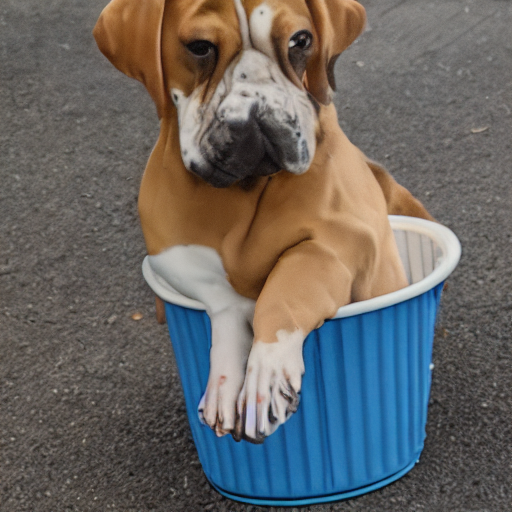

In [12]:
prompt = "a 5k photo of Molly dog in a bucket"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image